In [1]:
import requests
import json
import pandas as pd


from datetime import datetime, date, timedelta

In [2]:
url_example = "https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2014-01-09&endtime=2014-01-10"

In [3]:
today = date.today()
tomorrow = today + timedelta(1)

today_year, today_month, today_day = today.year, today.month, today.day
tomorrow_year, tomorrow_month, tomorrow_day = tomorrow.year, tomorrow.month, tomorrow.day

url = f"https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime={today_year}-{today_month}-{today_day}&endtime={tomorrow_year}-{tomorrow_month}-{tomorrow_day}"

print(url)

https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2024-7-9&endtime=2024-7-10


In [4]:
response = requests.get(url_example)

earthquake_json = response.json()

print(json.dumps(earthquake_json, indent=4))

{
    "type": "FeatureCollection",
    "metadata": {
        "generated": 1720558531000,
        "url": "https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2014-01-09&endtime=2014-01-10",
        "title": "USGS Earthquakes",
        "status": 200,
        "api": "1.14.1",
        "count": 315
    },
    "features": [
        {
            "type": "Feature",
            "properties": {
                "mag": 4.3,
                "place": "96 km SE of Kirakira, Solomon Islands",
                "time": 1389311979760,
                "updated": 1394854731000,
                "tz": null,
                "url": "https://earthquake.usgs.gov/earthquakes/eventpage/usb000m7du",
                "detail": "https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=usb000m7du&format=geojson",
                "felt": null,
                "cdi": null,
                "mmi": null,
                "alert": null,
                "status": "reviewed",
                "tsunami": 0,


In [5]:
time_list = []
mag_list = []
lon_list = []
lat_list = []
depth_list = []

features = earthquake_json["features"]

for feature in features:
    properties = feature["properties"]

    if properties["type"] == "earthquake":

        timestamp_ms = properties["time"]
        timestamp_s = timestamp_ms / 1000
        time = datetime.utcfromtimestamp(timestamp_s).strftime('%H:%M:%S')

        mag = properties["mag"]

        geometry = feature["geometry"]
        lon = geometry["coordinates"][0]
        lat = geometry["coordinates"][1]
        depth = geometry["coordinates"][2]

        time_list.append(time)
        mag_list.append(mag)
        lon_list.append(lon)
        lat_list.append(lat)
        depth_list.append(depth)

df = pd.DataFrame({
    "Time": time_list,
    "Magnitude": mag_list,
    "Longitude": lon_list,
    "Latitude": lat_list,
    "Depth": depth_list
}, index=None)

In [11]:
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt

In [34]:
earthquakes_geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
earthquakes_geodata = gpd.GeoDataFrame(df, 
                                crs="EPSG:4326", 
                                geometry=earthquakes_geometry)

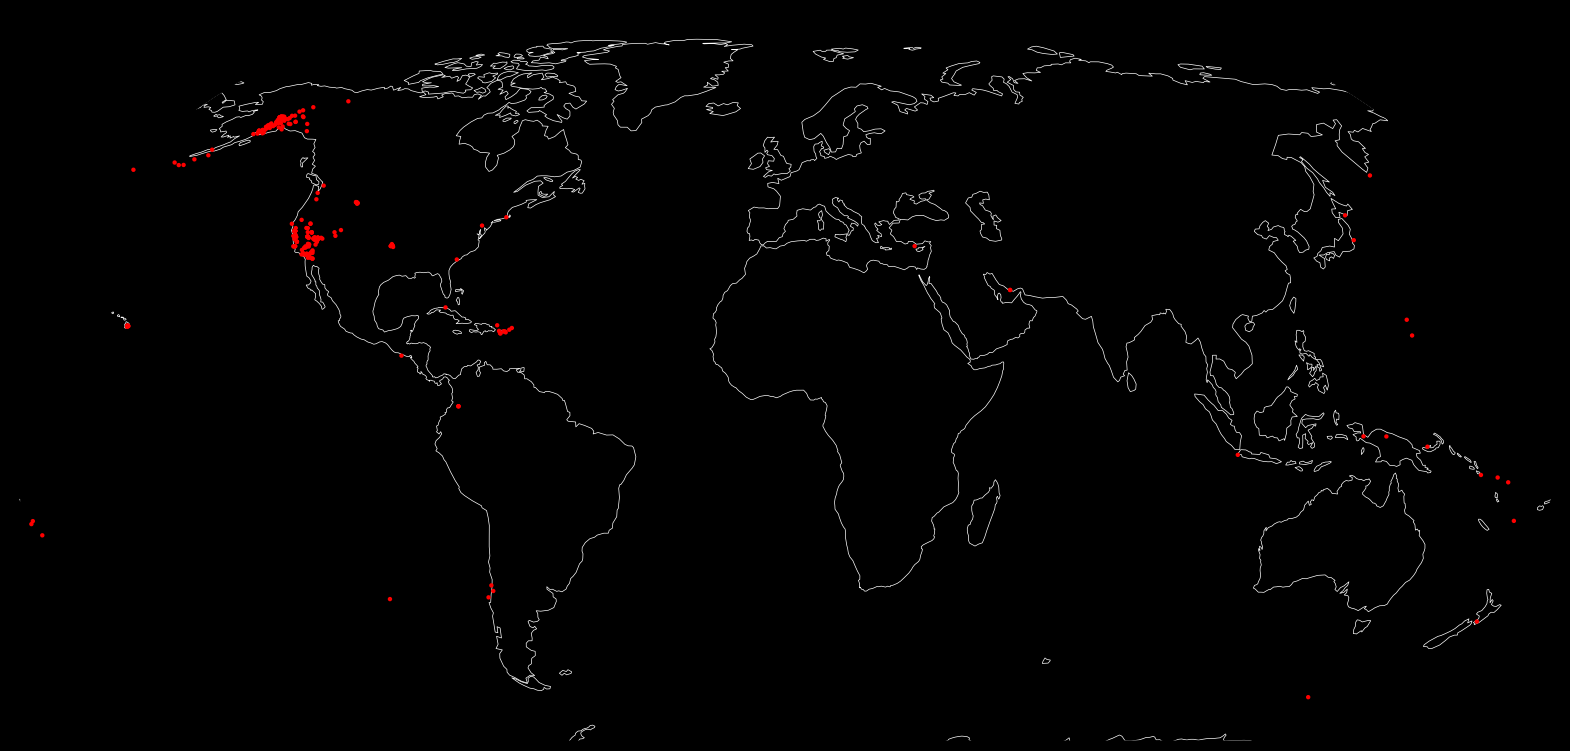

In [38]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, ax = plt.subplots(facecolor='black', 
                       subplot_kw={'projection': ccrs.Robinson()}, 
                       figsize=(20, 20))
ax.patch.set_facecolor('black')

# Ajout des contours des continents
ax.add_feature(cfeature.LAND, edgecolor='white', facecolor='none', linewidth=0.5)

earthquakes_geodata.plot(ax=ax, transform=ccrs.PlateCarree(),
                  markersize=10, alpha=1, edgecolors='none', color='red')

plt.setp(ax.spines.values(), color='black')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='black')
ax.set_ylim(-7000000, 9000000)
plt.show()